In [680]:
import os
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,acf, pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from itertools import product
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.compose import ColumnTransformer

os.chdir('/Users/arifakkan/Downloads/Project/Data')

In [681]:
crop='tomato'
#crop='eggplant'
#crop='cucumber'

In [682]:
def add_lag_features(df, max_lag):
    """
    Adds lag features for specified columns in the DataFrame.

    Parameters:
        df (DataFrame): The input DataFrame.
        column_names (list): List of column names to create lag features for.
        max_lag (int): The maximum number of lags to create.

    Returns:
        DataFrame: The DataFrame with added lag features.
    """
    for column_name in df.columns:
        for lag in range(1, max_lag + 1):
            df[f'{column_name}_Lag_{lag}'] = df[column_name].shift(lag)
    df.dropna(inplace=True)
    return df

def create_lag_features(df, max_lag):
    """
    Adds lag features for specified columns in the DataFrame.

    Parameters:
        df (DataFrame): The input DataFrame.
        column_names (list): List of column names to create lag features for.
        max_lag (int): The maximum number of lags to create.

    Returns:
        DataFrame: The DataFrame with added lag features.
    """
    for column_name in df.columns:
        if column_name!='price':
            for lag in range(1, max_lag + 1):
                df[f'{column_name}_Lag_{lag}'] = df[column_name].shift(lag)
            df=df.drop(column_name,axis=1)
    return df


def stationary_test(dataset):
    # Apply Augmented Dickey-Fuller test on the residual
    for column_name in dataset.columns:
        adf_test = adfuller(dataset[column_name].dropna())
        if adf_test[1] >= 0.05:
            print(f'{column_name} is non-stationary and may need further differencing or transformation.')
            print('ADF Statistic: %f' % adf_test[0])
            print('p-value: %f' % adf_test[1])

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: red' if v else '' for v in is_min]

In [683]:
datafile= crop + '.csv'

In [684]:
df = pd.read_csv(datafile)
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df=df[df.date>=pd.to_datetime('2011.1.1')]
df=df[df.date<pd.to_datetime('2020.1.1')]
df.set_index('date', inplace=True)
df = df.asfreq('M')
df= df.drop(columns=['Unnamed: 0'])

stationary_test(df)

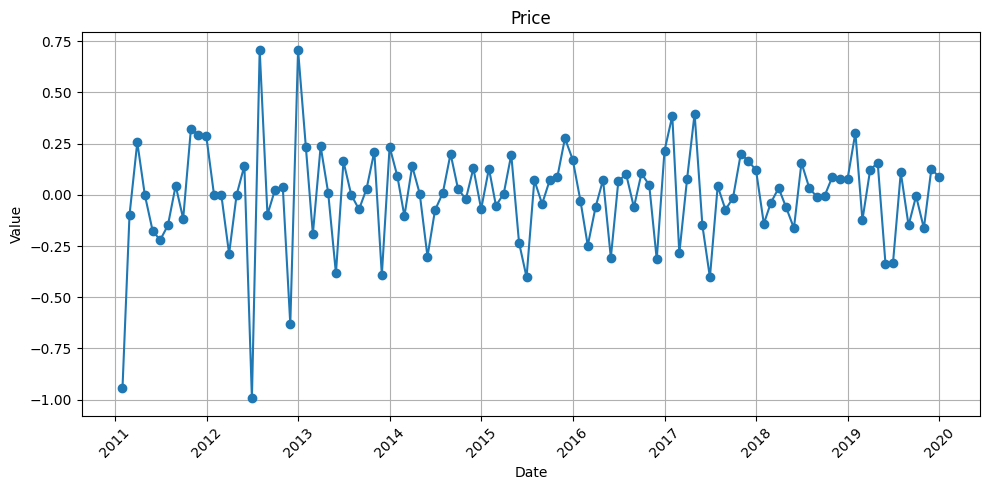

In [685]:

# Plotting
plt.figure(figsize=(10, 5))  # Set the figure size (optional)
plt.plot(df.index, df['price'], marker='o', linestyle='-')  # Line plot
plt.title('Price')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Value')  # Y-axis label
plt.grid(True)  # Show grid lines (optional)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability (optional)
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


In [686]:
df2 = df.drop(df.columns.difference(['price']), axis=1)
scaler2=StandardScaler()
pricesorg=scaler2.fit_transform(df2)

In [687]:
summary_stats = df[['tempdiff', 'mindiff', 'maxdiff', 'raind', 'hum']].describe()
print(summary_stats)

         tempdiff     mindiff     maxdiff       raind         hum
count  108.000000  108.000000  108.000000  108.000000  108.000000
mean     0.049725    0.108137   -0.008841    5.518426   61.317920
std      0.078602    0.137654    0.061690  112.734813    7.131347
min     -0.129706   -0.318495   -0.177226 -358.650000   42.244624
25%      0.004410    0.044126   -0.053739  -28.717500   55.882426
50%      0.039769    0.089521   -0.014059    0.365000   61.943408
75%      0.088842    0.166306    0.027821   34.652500   65.662348
max      0.324728    0.650769    0.184472  454.300000   81.068314


In [688]:
summary_stats = df[['tempdiff_man', 'mindiff_man', 'maxdiff_man', 'raind_man']].describe()
print(summary_stats)

       tempdiff_man  mindiff_man  maxdiff_man   raind_man
count    108.000000   108.000000   108.000000  108.000000
mean       0.049188     0.017231     0.029434   -1.918056
std        0.153804     0.271909     0.105662   43.619865
min       -0.395699    -0.853123    -0.220711 -154.520000
25%       -0.022684    -0.060490    -0.028163  -18.685000
50%        0.019227     0.001410     0.017300   -1.035000
75%        0.110782     0.123553     0.071920   22.675000
max        0.595284     0.831290     0.404918  140.290000


In [689]:
summary_stats = df[[ 'labor', 'gasprice', 'usd']].describe()
print(summary_stats)

            labor    gasprice         usd
count  108.000000  108.000000  108.000000
mean    -1.895625    0.005831    0.012501
std     33.208373    0.028752    0.035497
min   -140.162236   -0.075764   -0.086562
25%    -12.745286   -0.010099   -0.008762
50%     -3.492161    0.006973    0.011853
75%     11.018086    0.023416    0.027667
max    141.988339    0.059717    0.188025


In [690]:
# Splitting the data
split_point = int(0.85 * len(df))
train = df.iloc[:split_point]
test = df.iloc[split_point:]

y_train = train['price']
X_train = train.drop('price',axis=1)

y_test = test['price']
X_test = test.drop('price',axis=1)

In [691]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white
X_train_const = sm.add_constant(X_train)  # Adds a constant term to the predictor set

# Define the OLS model and fit it
model = sm.OLS(y_train, X_train_const)
results = model.fit()

# Get the residuals and the design matrix (independent variables)
residuals = results.resid
design_matrix = results.model.exog

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(residuals, design_matrix)

_, pvalue, _, _ = het_breuschpagan(residuals, X_train_const)
print('Breusch-Pagan p-value:', pvalue)

labels = ['Lagrange Multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))
# Perform the White test
white_test = het_white(residuals, design_matrix)
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

# Print the results
print(dict(zip(labels, white_test)))

rank = np.linalg.matrix_rank(design_matrix)
num_columns = design_matrix.shape[1]
print("Rank of the matrix:", rank)
print("Number of columns in the matrix:", num_columns)

# Check if the matrix has full rank
if rank == num_columns:
    print("The matrix is of full rank.")
else:
    print("The matrix is not of full rank.")

Breusch-Pagan p-value: 0.6983751286690532
{'Lagrange Multiplier statistic': 17.208779785178, 'p-value': 0.6983751286690532, 'f-value': 0.7662582813410784, 'f p-value': 0.7484245278259914}
{'Test Statistic': 91.0, 'Test Statistic p-value': 0.45068444675404107, 'F-Statistic': nan, 'F-Test p-value': nan}
Rank of the matrix: 22
Number of columns in the matrix: 22
The matrix is of full rank.


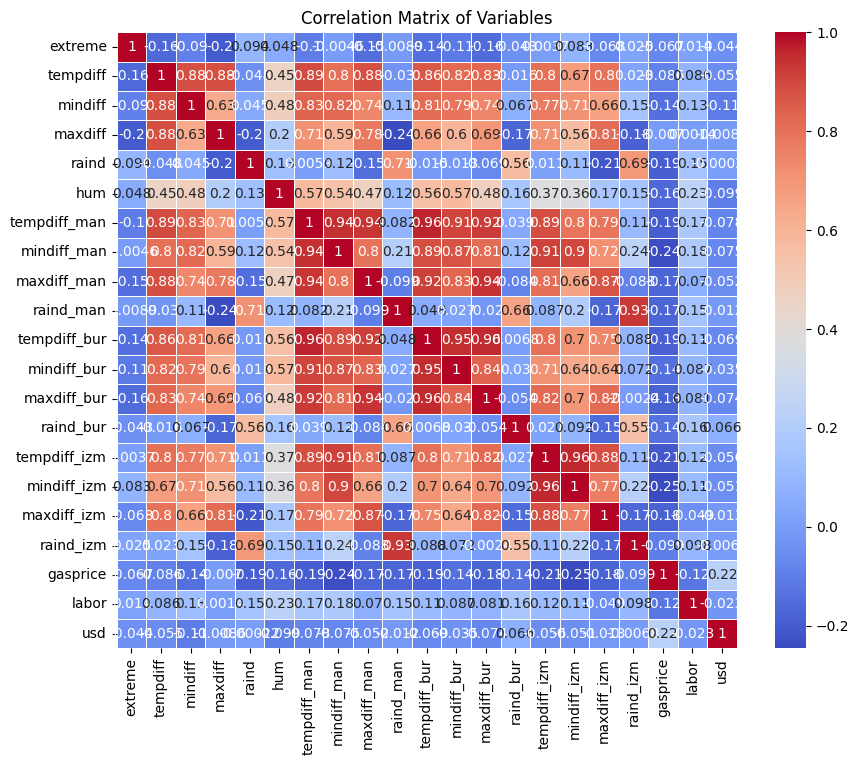

In [692]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_train already has a constant column removed for this analysis
correlation_matrix = X_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Variables')
plt.show()


In [694]:
max_lag=2
df=create_lag_features(df, max_lag=max_lag)
df.dropna(inplace=True)

numerical_features = df.drop(['extreme_Lag_1','extreme_Lag_2'], axis=1).columns.tolist()

# Create a ColumnTransformer that will scale only the numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'  # Do not scale other columns (e.g., dummy variables)
)
def scaler(df):
    # Fit and transform the data
    data_transformed = preprocessor.fit_transform(df)
    # Get the names of the features processed by each transformer, keeping their order
    transformed_columns = (numerical_features +
                           [col for col in df.columns if col not in numerical_features])
    df = pd.DataFrame(data_transformed, columns=transformed_columns, index=df.index)
    
    return df

df = scaler(df)

In [695]:
# Splitting the data
split_point = int(0.85 * len(df))
train = df.iloc[:split_point]
test = df.iloc[split_point:]

y_train = train['price']
X_train = train.drop('price',axis=1)

y_test = test['price']
X_test = test.drop('price',axis=1)

In [696]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white
X_train_const= sm.add_constant(X_train)  # Adds a constant term to the predictor set

# Define the OLS model and fit it
model = sm.OLS(y_train, X_train_const)
results = model.fit()

# Get the residuals and the design matrix (independent variables)
residuals = results.resid
design_matrix = results.model.exog

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(residuals, design_matrix)
labels = ['Lagrange Multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))
# Perform the White test
white_test = het_white(residuals, design_matrix)
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

# Print the results
print(dict(zip(labels, white_test)))

rank = np.linalg.matrix_rank(design_matrix)
num_columns = design_matrix.shape[1]
print("Rank of the matrix:", rank)
print("Number of columns in the matrix:", num_columns)

# Check if the matrix has full rank
if rank == num_columns:
    print("The matrix is of full rank.")
else:
    print("The matrix is not of full rank.")

{'Lagrange Multiplier statistic': 43.238696323214405, 'p-value': 0.4182036412496769, 'f-value': 1.0347478869635789, 'f p-value': 0.4527217870763467}
{'Test Statistic': 90.0, 'Test Statistic p-value': 0.45041089622203834, 'F-Statistic': nan, 'F-Test p-value': nan}
Rank of the matrix: 43
Number of columns in the matrix: 43
The matrix is of full rank.


## BASE MODEL SARIMAX

In [697]:
import itertools

# Parameter ranges
p_values = [0, 1, 2]  # AR(p) values
d_values = [0]  # Integrated order (d)
q_values = [0, 1, 2]  # MA(q) values
P_values = [0, 1, 2]  # Seasonal AR(P) values
D_values = [0]  # Seasonal integrated order (D)
Q_values = [0, 1, 2]  # Seasonal MA(Q) values
S_values = [12]  # Seasonal period (assuming monthly data)

# Create combinations of non-seasonal parameters [p, d, q]
non_seasonal_combinations = list(itertools.product(p_values, d_values, q_values))

# Create combinations of seasonal parameters [P, D, Q, S]
seasonal_combinations = list(itertools.product(P_values, D_values, Q_values, S_values))
combinations= list(itertools.product(non_seasonal_combinations, seasonal_combinations))
print(combinations)


[((0, 0, 0), (0, 0, 0, 12)), ((0, 0, 0), (0, 0, 1, 12)), ((0, 0, 0), (0, 0, 2, 12)), ((0, 0, 0), (1, 0, 0, 12)), ((0, 0, 0), (1, 0, 1, 12)), ((0, 0, 0), (1, 0, 2, 12)), ((0, 0, 0), (2, 0, 0, 12)), ((0, 0, 0), (2, 0, 1, 12)), ((0, 0, 0), (2, 0, 2, 12)), ((0, 0, 1), (0, 0, 0, 12)), ((0, 0, 1), (0, 0, 1, 12)), ((0, 0, 1), (0, 0, 2, 12)), ((0, 0, 1), (1, 0, 0, 12)), ((0, 0, 1), (1, 0, 1, 12)), ((0, 0, 1), (1, 0, 2, 12)), ((0, 0, 1), (2, 0, 0, 12)), ((0, 0, 1), (2, 0, 1, 12)), ((0, 0, 1), (2, 0, 2, 12)), ((0, 0, 2), (0, 0, 0, 12)), ((0, 0, 2), (0, 0, 1, 12)), ((0, 0, 2), (0, 0, 2, 12)), ((0, 0, 2), (1, 0, 0, 12)), ((0, 0, 2), (1, 0, 1, 12)), ((0, 0, 2), (1, 0, 2, 12)), ((0, 0, 2), (2, 0, 0, 12)), ((0, 0, 2), (2, 0, 1, 12)), ((0, 0, 2), (2, 0, 2, 12)), ((1, 0, 0), (0, 0, 0, 12)), ((1, 0, 0), (0, 0, 1, 12)), ((1, 0, 0), (0, 0, 2, 12)), ((1, 0, 0), (1, 0, 0, 12)), ((1, 0, 0), (1, 0, 1, 12)), ((1, 0, 0), (1, 0, 2, 12)), ((1, 0, 0), (2, 0, 0, 12)), ((1, 0, 0), (2, 0, 1, 12)), ((1, 0, 0), (2, 0, 

In [698]:
def fit_and_forecast(ordn, ord, y_train, X_train, y_test, X_test,queue=None):
    model = sm.tsa.statespace.SARIMAX(endog=y_train, exog=X_train, order=ord[0], seasonal_order=ord[1], enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False, maxiter=500)
    validation_forecast = results.forecast(steps=len(y_test), exog=X_test)
    # Calculate evaluation metrics
    val_mae = mean_absolute_error(y_test, validation_forecast)
    val_mse = mean_squared_error(y_test, validation_forecast)
    # Store results in a dictionary and add to queue
    return ({
        'Parameters': ordn,
        'MSE': val_mse,
        'MAE': val_mae})

In [699]:
test_size=len(y_test)
resultlist=[]
errorlist=pd.DataFrame(columns=['Parameters', 'MSE','MAE'])
for ordn, ord in enumerate(combinations):
    print(f'at the {ordn}')
    new_observation=fit_and_forecast(ordn, ord,y_train, X_train, y_test, X_test)
    # Converting the dictionary to a DataFrame
    resultlist.append(new_observation)


at the 0
at the 1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 2


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 3


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 4


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 6


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 7


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 9


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 11


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 12


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 13


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 14


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 15


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 16


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 17


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 18


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 19


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 20
at the 21


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 22


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 23
at the 24


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 25


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 26
at the 27


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 28


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 29


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 31


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 32


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 33


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 34


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 35


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 36


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 37


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 38


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 39


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 40


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 41


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 42


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 43


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 44


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 45


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 46


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 47


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 48


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 49


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 51


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 52


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 53


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 54


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 55


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 56


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 57


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 58


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 59


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 60


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 61


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 62


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 63


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 65
at the 66


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 67


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 68
at the 69


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 70


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 71
at the 72


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 73


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 74


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 75


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 76


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 77
at the 78


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 79


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


at the 80


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [700]:
resultlistsar=pd.DataFrame(data=resultlist, columns=['Parameters','MSE', 'MAE'])

In [701]:
idx = resultlistsar['MSE'].idxmin()

# Select these rows from the original DataFrame
best_scores_sarimax = resultlistsar.loc[idx]

In [702]:
print(f'Best parameters for the validation set Mean Squared Errors is {combinations[idx]}')

Best parameters for the validation set Mean Squared Errors is ((1, 0, 2), (0, 0, 0, 12))


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


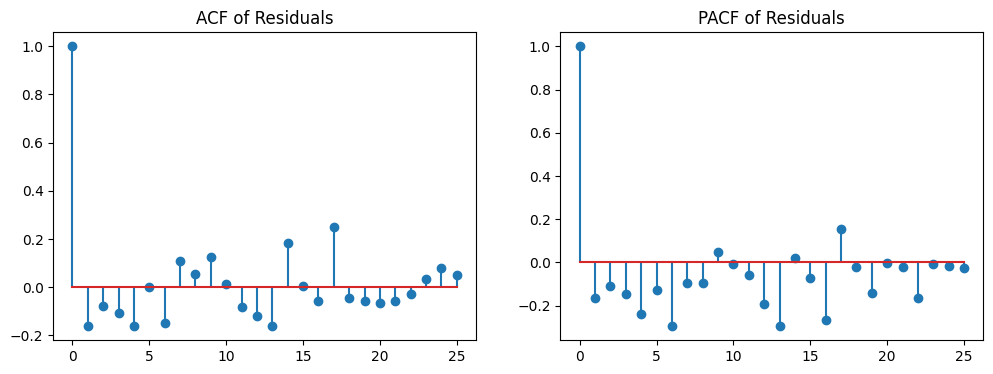

Mean Squared Error (MSE): 1.4556069339018551
Root Mean Squared Error (RMSE): 1.2064853641473878
 Mean Absolute Error (RMSE): 1.0945497133837727


In [703]:
# Forecasting
forecast_steps = len(y_test) # Number of steps to forecast
bestvalorder=combinations[idx]

model = sm.tsa.statespace.SARIMAX(endog=y_train, exog=X_train, order=(bestvalorder[0]), 
                                  seasonal_order=bestvalorder[1])
results = model.fit(disp=False, maxiter=1000)

# Diagnostic Checks
# ACF and PACF plots for residuals
residuals = results.resid
acf_vals = acf(residuals, fft=False, nlags=25)
pacf_vals = pacf(residuals, nlags=25)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.stem(acf_vals)
plt.title('ACF of Residuals')
plt.subplot(1, 2, 2)
plt.stem(pacf_vals)
plt.title('PACF of Residuals')
plt.show()


validation_forecast = results.forecast(steps=forecast_steps, exog=X_test)

# Calculate evaluation metrics
base_mae_model1 = mean_absolute_error(y_test, validation_forecast)
base_mse_model1 = mean_squared_error(y_test, validation_forecast)
base_rmse_model1 = np.sqrt(base_mse_model1)

print(f'Mean Squared Error (MSE): {base_mse_model1}')
print(f'Root Mean Squared Error (RMSE): {base_rmse_model1}')
print(f' Mean Absolute Error (RMSE): {base_mae_model1}')


In [704]:
y_pred_org = scaler2.inverse_transform(np.array(validation_forecast).reshape(1,-1))
actual= pd.read_csv(f'actprice{crop}.csv')
actual['date'] = pd.to_datetime(actual['date'],format='%Y-%m-%d')
actual=actual[actual.date>=pd.to_datetime('2018-08-28')]
actual=actual[actual.date<pd.to_datetime('2020.1.1')]
actual.set_index('date', inplace=True)
actual = actual.asfreq('M')
actual= actual.drop(columns=['Unnamed: 0'])

def reverse_log_difference(predictions, initial_value):
    # Convert log differences back to log scale
    cumulative_log = np.cumsum(np.insert(predictions, 0, initial_value))
    # Exponentiate to get back to the original scale
    original_scale = np.exp(cumulative_log)
    return original_scale

initial_value = np.log(actual.iloc[0])

# Get the predictions on the original scale
act_scale_pred = reverse_log_difference(y_pred_org, initial_value)

base_mse_act= mean_squared_error(actual, act_scale_pred)
base_mape_act = mean_absolute_percentage_error(actual, act_scale_pred)
base_mae_act = mean_absolute_error(actual, act_scale_pred)
base_rmse_act= np.sqrt(base_mse_act)

print("Test RMSE:", base_rmse_act)
print("Test MSE:", base_mse_act )
print("Test MAE:", base_mae_act )
print("Test MAPE:",base_mape_act )

Test RMSE: 1.0300160654565793
Test MSE: 1.0609330950986522
Test MAE: 0.8631461076840954
Test MAPE: 0.3862293138451111


# Machine Learning

In [705]:
df = pd.read_csv(datafile)
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df=df[df.date>=pd.to_datetime('2011.1.1')]
df=df[df.date<pd.to_datetime('2020.1.1')]
df.set_index('date', inplace=True)
df = df.asfreq('M')
df= df.drop(columns=['Unnamed: 0'])

In [706]:

numerical_features = df.drop(['extreme'], axis=1).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough' 
)
def scaler(df):
    numerical_features = df.drop(['extreme'], axis=1).columns.tolist()

    # Fit and transform the data
    data_transformed = preprocessor.fit_transform(df)
    # Get the names of the features processed by each transformer, keeping their order
    transformed_columns = (numerical_features +
                           [col for col in df.columns if col not in numerical_features])
    df = pd.DataFrame(data_transformed, columns=transformed_columns, index=df.index)
    
    return df

df= scaler(df)

In [707]:
max_lag=2
df=create_lag_features(df, max_lag=max_lag)
for lag in range(1, max_lag + 1):
    df[f'price_Lag_{lag}'] = df['price'].shift(lag)
df.dropna(inplace=True)

In [708]:
# redefining train and test
split_point = int(0.85 * len(df))
train = df.iloc[:split_point]
test = df.iloc[split_point:]

X_train = train.drop('price', axis=1)
y_train = train['price']
X_test = test.drop('price', axis=1)
y_test = test['price']

In [709]:
from sklearn.model_selection import BaseCrossValidator
class MovingWindowValidation(BaseCrossValidator):
    def __init__(self, window_size):
        """
        window_size: Number of observations to include in each training set
        """
        self.window_size = window_size
    
    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set."""
        n_samples = len(X)
        self.n_splits = n_samples - self.window_size  # Compute number of splits
        
        for i in range(self.n_splits):
            train_start, train_end = i, i + self.window_size
            test_start, test_end = train_end, train_end + 1
            yield (np.arange(train_start, train_end), np.arange(test_start, test_end))
    
    def get_n_splits(self, X=None, y=None, groups=None):
        """Returns the number of splitting iterations in the cross-validator."""
        n_samples = len(X)
        self.n_splits = n_samples - self.window_size

        return self.n_splits

In [710]:
#Multiple Scorers
from sklearn.metrics import make_scorer

scoring = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False)
}

In [711]:
test_fold = np.full(X_train.shape[0], -1)  # Training set
test_fold = np.concatenate([test_fold, np.zeros(X_test.shape[0])])  # Validation set
X = np.vstack((X_train, X_test))
y= np.concatenate((y_train, y_test))

In [712]:
from sklearn.model_selection import PredefinedSplit
ps = PredefinedSplit(test_fold)

parameters = {
    'C': [0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10],
    'epsilon': [0.001, 0.01, 0.1, 0.5, 1, 10],
    'kernel': ['rbf','linear','poly'],
    'gamma' : ['scale','auto', 0.1, 1, 10, 100 ]
}

svr = SVR()
grid_search_SVR = GridSearchCV(svr, parameters, cv=ps, scoring=scoring, refit='MSE', return_train_score=True)
grid_search_SVR.fit(X, y)
best_model = grid_search_SVR.best_estimator_
print("Best parameters:", grid_search_SVR.best_params_)
print("Best cross-validation score: ", -grid_search_SVR.best_score_)

Best parameters: {'C': 1, 'epsilon': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score:  0.4387539586705724


In [713]:
results = pd.DataFrame(grid_search_SVR.cv_results_)
results = results[['param_C', 'mean_train_MSE', 'mean_test_MSE','mean_train_MAE', 'mean_test_MAE']]
results['mean_train_MSE'] = -results['mean_train_MSE']
results['mean_test_MSE'] = -results['mean_test_MSE']
results['mean_train_MAE'] = -results['mean_train_MAE']
results['mean_test_MAE'] = -results['mean_test_MAE']
results= results.rename(columns={'mean_test_MSE': 'Cross Validation MSE', 'mean_train_MSE': 'Training Set MSE',
                                  'mean_test_MAE': 'Cross Validation MAE', 'mean_train_MAE': 'Training Set MAE'} )
idx = results.groupby('param_C')['Cross Validation MSE'].idxmin()

# Select these rows from the original DataFrame
best_scores = results.loc[idx]

styled_results = best_scores.style.apply(highlight_min, subset=['Training Set MSE','Training Set MAE',  'Cross Validation MSE', 'Cross Validation MAE' ])

# Display styled DataFrame
styled_results

,param_C,Training Set MSE,Cross Validation MSE,Training Set MAE,Cross Validation MAE
1,0.000010,0.950250,0.485134,0.679308,0.566719
127,0.000100,0.945534,0.483868,0.676273,0.564608
271,0.001000,0.920574,0.457677,0.669425,0.547514
379,0.010000,0.815449,0.445091,0.624680,0.511325
507,0.100000,0.908904,0.476434,0.685960,0.592294
612,1,0.655139,0.438754,0.596133,0.527990
726,10,0.433561,0.470124,0.552207,0.570964


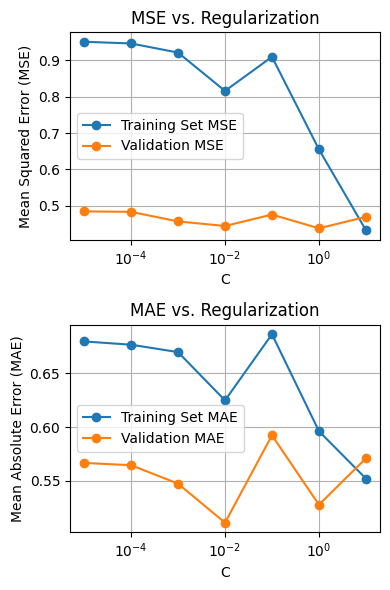

In [714]:
import matplotlib.pyplot as plt
import pandas as pd

results = pd.DataFrame(grid_search_SVR.cv_results_)
results = results[['param_C', 'mean_train_MSE', 'mean_test_MSE','mean_train_MAE', 'mean_test_MAE']]
results['mean_train_MSE'] = -results['mean_train_MSE']
results['mean_test_MSE'] = -results['mean_test_MSE']
results['mean_train_MAE'] = -results['mean_train_MAE']
results['mean_test_MAE'] = -results['mean_test_MAE']
results= results.rename(columns={'mean_test_MSE': 'Validation MSE', 'mean_train_MSE': 'Training Set MSE',
                                  'mean_test_MAE': 'Validation MAE', 'mean_train_MAE': 'Training Set MAE'} )
idx = results.groupby('param_C')['Validation MSE'].idxmin()

# Select these rows from the original DataFrame
results= results.loc[idx]

# Plotting
plt.figure(figsize=(4, 6))

# MSE plot
plt.subplot(2, 1, 1)  # subplot with 1 row, 2 columns, position 1
plt.plot(results['param_C'], results['Training Set MSE'], label='Training Set MSE', marker='o')
plt.plot(results['param_C'], results['Validation MSE'], label='Validation MSE', marker='o')
plt.title('MSE vs. Regularization')
plt.xlabel('C')
plt.ylabel('Mean Squared Error (MSE)')
plt.xscale('log')  # Since alpha values usually vary exponentially
plt.legend()
plt.grid(True)

# MAE plot
plt.subplot(2, 1, 2)  # subplot with 1 row, 2 columns, position 2
plt.plot(results['param_C'], results['Training Set MAE'], label='Training Set MAE', marker='o')
plt.plot(results['param_C'], results['Validation MAE'], label='Validation MAE', marker='o')
plt.title('MAE vs. Regularization')
plt.xlabel('C')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xscale('log')  # Since alpha values usually vary exponentially
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [715]:
results = pd.DataFrame(grid_search_SVR.cv_results_)
results = results[['param_epsilon', 'mean_train_MSE', 'mean_test_MSE','mean_train_MAE', 'mean_test_MAE']]
results['mean_train_MSE'] = -results['mean_train_MSE']
results['mean_test_MSE'] = -results['mean_test_MSE']
results['mean_train_MAE'] = -results['mean_train_MAE']
results['mean_test_MAE'] = -results['mean_test_MAE']
results= results.rename(columns={'mean_test_MSE': 'Cross Validation MSE', 'mean_train_MSE': 'Training Set MSE',
                                  'mean_test_MAE': 'Cross Validation MAE', 'mean_train_MAE': 'Training Set MAE'} )
idx = results.groupby('param_epsilon')['Cross Validation MSE'].idxmin()

# Select these rows from the original DataFrame
best_scores = results.loc[idx]

styled_results = best_scores.style.apply(highlight_min, subset=['Training Set MSE','Training Set MAE',  'Cross Validation MSE', 'Cross Validation MAE' ])

# Display styled DataFrame
styled_results

,param_epsilon,Training Set MSE,Cross Validation MSE,Training Set MAE,Cross Validation MAE
109,0.001000,0.945690,0.484497,0.676433,0.565688
127,0.010000,0.945534,0.483868,0.676273,0.564608
696,0.100000,0.008867,0.484422,0.090549,0.570737
379,0.500000,0.815449,0.445091,0.624680,0.511325
612,1,0.655139,0.438754,0.596133,0.527990
90,10,1.306263,0.828143,0.912725,0.792791


In [716]:

model = SVR(**grid_search_SVR.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_mse_svr = mean_squared_error(y_test, y_pred)
test_mae_svr = mean_absolute_error(y_test, y_pred)
print(test_mse_svr)
print(test_mae_svr)

0.4387539586705724
0.5279900873916916


In [717]:
y_pred_org = scaler2.inverse_transform(y_pred.reshape(-1,1))

# Get the predictions on the original scale
act_scale_pred = reverse_log_difference(y_pred_org, initial_value)

svr_mse_act= mean_squared_error(actual, act_scale_pred)
svr_mape_act = mean_absolute_percentage_error(actual, act_scale_pred)
svr_mae_act = mean_absolute_error(actual, act_scale_pred)
svr_rmse_act= np.sqrt(svr_mse_act)

print("Test RMSE:", svr_rmse_act)
print("Test MSE:", svr_mse_act )
print("Test MAE:", svr_mae_act )
print("Test MAPE:",svr_mape_act )

Test RMSE: 0.6020109508418249
Test MSE: 0.3624171849334781
Test MAE: 0.44988813367437924
Test MAPE: 0.19593060339077636


## LASSO RIDGE

In [718]:
from sklearn.linear_model import Lasso, Ridge

lasso_model = Lasso(max_iter=1000, tol=1e-3)

lasso_param_grid = {
    'alpha':[0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10, 100]
}

lasso_grid_search = GridSearchCV(estimator=lasso_model, param_grid=lasso_param_grid, scoring=scoring, cv=ps, refit='MSE', verbose=1, return_train_score=True)
lasso_grid_search.fit(X, y)

Fitting 1 folds for each of 8 candidates, totalling 8 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.458e+01, tolerance: 8.554e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.552e+00, tolerance: 8.554e-02
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Lasso(tol=0.001),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10, 100]},
             refit='MSE', return_train_score=True,
             scoring={'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
                      'MSE': make_scorer(mean_squared_error, greater_is_better=False)},
             verbose=1)

In [719]:

results = pd.DataFrame(lasso_grid_search.cv_results_)
results = results[['param_alpha', 'mean_train_MSE', 'mean_test_MSE','mean_train_MAE', 'mean_test_MAE']]
results['mean_train_MSE'] = -results['mean_train_MSE']
results['mean_test_MSE'] = -results['mean_test_MSE']
results['mean_train_MAE'] = -results['mean_train_MAE']
results['mean_test_MAE'] = -results['mean_test_MAE']
results= results.rename(columns={'mean_test_MSE': 'Cross Validation MSE', 'mean_train_MSE': 'Training Set MSE',
                                  'mean_test_MAE': 'Cross Validation MAE', 'mean_train_MAE': 'Training Set MAE'} )
idx = results.groupby('param_alpha')['Cross Validation MSE'].idxmin()

# Select these rows from the original DataFrame
best_scores = results.loc[idx]

styled_results = best_scores.style.apply(highlight_min, subset=['Training Set MSE','Training Set MAE',  'Cross Validation MSE', 'Cross Validation MAE' ])

# Display styled DataFrame
styled_results

,param_alpha,Training Set MSE,Cross Validation MSE,Training Set MAE,Cross Validation MAE
0,0.000100,0.406567,0.810685,0.476428,0.759479
1,0.001000,0.412561,0.734918,0.486531,0.717119
2,0.010000,0.462488,0.519919,0.512257,0.546301
3,0.100000,0.805609,0.491041,0.635636,0.576707
4,0.500000,0.950405,0.484526,0.680306,0.569608
5,1,0.950405,0.484526,0.680306,0.569608
6,10,0.950405,0.484526,0.680306,0.569608
7,100,0.950405,0.484526,0.680306,0.569608


In [720]:
testmodel = Lasso(**lasso_grid_search.best_params_, max_iter=1000, tol=1e-3)

testmodel.fit(X_train, y_train)
y_pred = testmodel.predict(X_test)
test_mse_lasso = mean_squared_error(y_test, y_pred)
test_mae_lasso = mean_absolute_error(y_test, y_pred)
print(test_mse_lasso)
print(test_mae_lasso)

print(testmodel.coef_)

non_zero_coeffs = testmodel.coef_
non_zero_features = X_train.columns[non_zero_coeffs != 0]

print("Non-Zero Coefficients:")
for feature, coeff in zip(non_zero_features, non_zero_coeffs[non_zero_coeffs != 0]):
    print(f"{feature}: {coeff}")

0.4845260182450775
0.5696075211596037
[ 0.  0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0.
  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.
 -0.  0.  0.  0.  0. -0. -0. -0.]
Non-Zero Coefficients:


In [721]:
y_pred_org = scaler2.inverse_transform(y_pred.reshape(-1,1))
# Get the predictions on the original scale
act_scale_pred = reverse_log_difference(y_pred_org, initial_value)

lasso_mse_act= mean_squared_error(actual, act_scale_pred)
lasso_mape_act = mean_absolute_percentage_error(actual, act_scale_pred)
lasso_mae_act = mean_absolute_error(actual, act_scale_pred)
lasso_rmse_act= np.sqrt(lasso_mse_act)

print("Test RMSE:", lasso_rmse_act)
print("Test MSE:", lasso_mse_act )
print("Test MAE:", lasso_mae_act )
print("Test MAPE:",lasso_mape_act )

Test RMSE: 0.6690307672589209
Test MSE: 0.44760216753906035
Test MAE: 0.45266296013662843
Test MAPE: 0.17578686023622375


## RIDGE

In [722]:
ridge_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1, 10, 100,250, 500, 1000]
}
ridge_model = Ridge(max_iter=5000, tol=1e-3)
ridge_grid_search = GridSearchCV(estimator=ridge_model, param_grid=ridge_param_grid, scoring=scoring, cv=ps,refit='MSE', verbose=1,return_train_score=True)

ridge_grid_search.fit(X, y)

Fitting 1 folds for each of 10 candidates, totalling 10 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Ridge(max_iter=5000, tol=0.001),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1, 10, 100, 250, 500,
                                   1000]},
             refit='MSE', return_train_score=True,
             scoring={'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
                      'MSE': make_scorer(mean_squared_error, greater_is_better=False)},
             verbose=1)

In [723]:
results = pd.DataFrame(ridge_grid_search.cv_results_)
results = results[['param_alpha', 'mean_train_MSE', 'mean_test_MSE','mean_train_MAE', 'mean_test_MAE']]
results['mean_train_MSE'] = -results['mean_train_MSE']
results['mean_test_MSE'] = -results['mean_test_MSE']
results['mean_train_MAE'] = -results['mean_train_MAE']
results['mean_test_MAE'] = -results['mean_test_MAE']
results= results.rename(columns={'mean_test_MSE': 'Validation MSE', 'mean_train_MSE': 'Training Set MSE',
                                  'mean_test_MAE': 'Validation MAE', 'mean_train_MAE': 'Training Set MAE'} )
idx = results.groupby('param_alpha')['Validation MSE'].idxmin()

# Select these rows from the original DataFrame
best_scores = results.loc[idx]

styled_results = best_scores.style.apply(highlight_min, subset=['Training Set MSE','Training Set MAE',  'Validation MSE', 'Validation MAE' ])

# Display styled DataFrame
styled_results

,param_alpha,Training Set MSE,Validation MSE,Training Set MAE,Validation MAE
0,0.001000,0.403687,0.778820,0.476904,0.726897
1,0.010000,0.403854,0.781972,0.477787,0.728869
2,0.100000,0.408660,0.782665,0.485160,0.731306
3,0.500000,0.423097,0.709428,0.497816,0.688852
4,1,0.433151,0.655635,0.503280,0.653842
5,10,0.511102,0.565179,0.526665,0.599175
6,100,0.737674,0.500933,0.599943,0.581255
7,250,0.826918,0.479681,0.632900,0.569626
8,500,0.874887,0.473802,0.652023,0.565432
9,1000,0.906318,0.473671,0.664409,0.563730


In [724]:
testmodel2 = Ridge(**ridge_grid_search.best_params_, max_iter=10000, tol=1e-3)
testmodel2.fit(X_train, y_train)
y_pred = testmodel2.predict(X_test)
test_mse_ridge = mean_squared_error(y_test, y_pred)
test_mae_ridge = mean_absolute_error(y_test, y_pred)
print(test_mse_ridge)
print(test_mae_ridge)

0.47367128619462917
0.5637302038234098


In [725]:
y_pred_org = scaler2.inverse_transform(y_pred.reshape(-1,1))

# Get the predictions on the original scale
act_scale_pred = reverse_log_difference(y_pred_org, initial_value)

ridge_mse_act= mean_squared_error(actual, act_scale_pred)
ridge_mape_act = mean_absolute_percentage_error(actual, act_scale_pred)
ridge_mae_act = mean_absolute_error(actual, act_scale_pred)
ridge_rmse_act= np.sqrt(ridge_mse_act)

print("Test RMSE:", ridge_rmse_act)
print("Test MSE:", ridge_mse_act )
print("Test MAE:", ridge_mae_act )
print("Test MAPE:",ridge_mape_act )

Test RMSE: 0.6604117218957121
Test MSE: 0.4361436424172593
Test MAE: 0.4566797499530302
Test MAPE: 0.1808475513931478


## XGBoost

In [726]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Create a parameter grid
param_grid = {
    'max_depth': [1,2,3, 5],
    'min_child_weight': [1, 3, 5, 7],
    'learning_rate': [0.2,0.5, 0.8],
    'n_estimators': [10, 20, 30,50, 70,100, 150],
    'alpha':[0,0.1, 1, 10],
    'reg_lambda':[0, 1, 10, 100, 250, 500]
}

# Setup GridSearchCV
grid_searchXG = GridSearchCV(estimator=model, param_grid=param_grid, cv=ps, n_jobs=-1,scoring=scoring, refit='MSE', return_train_score=True, verbose=1)

# Fit GridSearchCV
grid_searchXG.fit(X, y)

# Best parameters and best score
print("Best parameters:", grid_searchXG.best_params_)
print("Best score:", -grid_searchXG.best_score_)

Fitting 1 folds for each of 8064 candidates, totalling 8064 fits
Best parameters: {'alpha': 1, 'learning_rate': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 10, 'reg_lambda': 1}
Best score: 0.365986585068771


In [727]:
results = pd.DataFrame(grid_searchXG.cv_results_)
results = results[['param_max_depth', 'mean_train_MSE', 'mean_test_MSE','mean_train_MAE', 'mean_test_MAE']]
results['mean_train_MSE'] = -results['mean_train_MSE']
results['mean_test_MSE'] = -results['mean_test_MSE']
results['mean_train_MAE'] = -results['mean_train_MAE']
results['mean_test_MAE'] = -results['mean_test_MAE']
results= results.rename(columns={'mean_test_MSE': 'Cross Validation MSE', 'mean_train_MSE': 'Training Set MSE',
                                  'mean_test_MAE': 'Cross Validation MAE', 'mean_train_MAE': 'Training Set MAE'} )
idx = results.groupby('param_max_depth')['Cross Validation MSE'].idxmin()

# Select these rows from the original DataFrame
best_scores = results.loc[idx]

styled_results = best_scores.style.apply(highlight_min, subset=['Training Set MSE','Training Set MAE',  'Cross Validation MSE', 'Cross Validation MAE' ])

# Display styled DataFrame
styled_results

,param_max_depth,Training Set MSE,Cross Validation MSE,Training Set MAE,Cross Validation MAE
5379,1,0.750139,0.487445,0.602037,0.525578
6223,2,0.705501,0.521865,0.577845,0.560194
7856,3,0.634804,0.461740,0.544897,0.531236
5209,5,0.035210,0.365987,0.109844,0.483507


In [728]:
results = pd.DataFrame(grid_searchXG.cv_results_)
results = results[['param_alpha', 'mean_train_MSE', 'mean_test_MSE','mean_train_MAE', 'mean_test_MAE']]
results['mean_train_MSE'] = -results['mean_train_MSE']
results['mean_test_MSE'] = -results['mean_test_MSE']
results['mean_train_MAE'] = -results['mean_train_MAE']
results['mean_test_MAE'] = -results['mean_test_MAE']
results= results.rename(columns={'mean_test_MSE': 'Cross Validation MSE', 'mean_train_MSE': 'Training Set MSE',
                                  'mean_test_MAE': 'Cross Validation MAE', 'mean_train_MAE': 'Training Set MAE'} )
idx = results.groupby('param_alpha')['Cross Validation MSE'].idxmin()

# Select these rows from the original DataFrame
best_scores = results.loc[idx]

styled_results = best_scores.style.apply(highlight_min, subset=['Training Set MSE','Training Set MAE',  'Cross Validation MSE', 'Cross Validation MAE' ])

# Display styled DataFrame
styled_results

,param_alpha,Training Set MSE,Cross Validation MSE,Training Set MAE,Cross Validation MAE
1977,0,0.421583,0.457719,0.410544,0.520109
3999,0.100000,0.229172,0.451167,0.270704,0.513951
5209,1,0.035210,0.365987,0.109844,0.483507
7856,10,0.634804,0.461740,0.544897,0.531236


In [729]:
results = pd.DataFrame(grid_searchXG.cv_results_)
results = results[['param_reg_lambda', 'mean_train_MSE', 'mean_test_MSE','mean_train_MAE', 'mean_test_MAE']]
results['mean_train_MSE'] = -results['mean_train_MSE']
results['mean_test_MSE'] = -results['mean_test_MSE']
results['mean_train_MAE'] = -results['mean_train_MAE']
results['mean_test_MAE'] = -results['mean_test_MAE']
results= results.rename(columns={'mean_test_MSE': 'Cross Validation MSE', 'mean_train_MSE': 'Training Set MSE',
                                  'mean_test_MAE': 'Cross Validation MAE', 'mean_train_MAE': 'Training Set MAE'} )
idx = results.groupby('param_reg_lambda')['Cross Validation MSE'].idxmin()

# Select these rows from the original DataFrame
best_scores = results.loc[idx]

styled_results = best_scores.style.apply(highlight_min, subset=['Training Set MSE','Training Set MAE',  'Cross Validation MSE', 'Cross Validation MAE' ])

# Display styled DataFrame
styled_results

,param_reg_lambda,Training Set MSE,Cross Validation MSE,Training Set MAE,Cross Validation MAE
4578,0,0.138282,0.388021,0.252112,0.458526
5209,1,0.035210,0.365987,0.109844,0.483507
2528,10,0.148563,0.459906,0.200973,0.504337
3999,100,0.229172,0.451167,0.270704,0.513951
1354,250,0.742276,0.492733,0.598224,0.542457
7385,500,0.634598,0.493685,0.539350,0.528876


In [730]:
results = pd.DataFrame(grid_searchXG.cv_results_)
results = results[['param_n_estimators', 'mean_train_MSE', 'mean_test_MSE','mean_train_MAE', 'mean_test_MAE']]
results['mean_train_MSE'] = -results['mean_train_MSE']
results['mean_test_MSE'] = -results['mean_test_MSE']
results['mean_train_MAE'] = -results['mean_train_MAE']
results['mean_test_MAE'] = -results['mean_test_MAE']
results= results.rename(columns={'mean_test_MSE': 'Cross Validation MSE', 'mean_train_MSE': 'Training Set MSE',
                                  'mean_test_MAE': 'Cross Validation MAE', 'mean_train_MAE': 'Training Set MAE'} )
idx = results.groupby('param_n_estimators')['Cross Validation MSE'].idxmin()

# Select these rows from the original DataFrame
best_scores = results.loc[idx]

styled_results = best_scores.style.apply(highlight_min, subset=['Training Set MSE','Training Set MAE',  'Cross Validation MSE', 'Cross Validation MAE' ])

# Display styled DataFrame
styled_results

,param_n_estimators,Training Set MSE,Cross Validation MSE,Training Set MAE,Cross Validation MAE
5209,10,0.035210,0.365987,0.109844,0.483507
5215,20,0.015621,0.372952,0.064907,0.495227
5221,30,0.015621,0.372952,0.064907,0.495227
5227,50,0.015621,0.372952,0.064907,0.495227
5233,70,0.015621,0.372952,0.064907,0.495227
5239,100,0.015621,0.372952,0.064907,0.495227
5245,150,0.015621,0.372952,0.064907,0.495227


In [731]:
results = pd.DataFrame(grid_searchXG.cv_results_)
results = results[['param_min_child_weight', 'mean_train_MSE', 'mean_test_MSE','mean_train_MAE', 'mean_test_MAE']]
results['mean_train_MSE'] = -results['mean_train_MSE']
results['mean_test_MSE'] = -results['mean_test_MSE']
results['mean_train_MAE'] = -results['mean_train_MAE']
results['mean_test_MAE'] = -results['mean_test_MAE']
results= results.rename(columns={'mean_test_MSE': 'Cross Validation MSE', 'mean_train_MSE': 'Training Set MSE',
                                  'mean_test_MAE': 'Cross Validation MAE', 'mean_train_MAE': 'Training Set MAE'} )
idx = results.groupby('param_min_child_weight')['Cross Validation MSE'].idxmin()

# Select these rows from the original DataFrame
best_scores = results.loc[idx]

styled_results = best_scores.style.apply(highlight_min, subset=['Training Set MSE','Training Set MAE',  'Cross Validation MSE', 'Cross Validation MAE' ])

# Display styled DataFrame
styled_results

,param_min_child_weight,Training Set MSE,Cross Validation MSE,Training Set MAE,Cross Validation MAE
5209,1,0.035210,0.365987,0.109844,0.483507
4578,3,0.138282,0.388021,0.252112,0.458526
3957,5,0.210843,0.468079,0.246020,0.517510
3999,7,0.229172,0.451167,0.270704,0.513951


In [732]:
import xgboost as xgb
model = xgb.XGBRegressor(objective='reg:squarederror', **grid_searchXG.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_mse_xg = mean_squared_error(y_test, y_pred)
test_mae_xg = mean_absolute_error(y_test, y_pred)
print(test_mse_xg)
print(test_mae_xg)

0.365986585068771
0.483506970050377


In [733]:
model_dump_json = model.get_booster().get_dump(dump_format='json')
for tree in model_dump_json:
    print(tree)


  { "nodeid": 0, "depth": 0, "split": "price_Lag_1", "split_condition": -2.06984448, "yes": 1, "no": 2, "missing": 1 , "children": [
    { "nodeid": 1, "leaf": 0.62886101 }, 
    { "nodeid": 2, "depth": 1, "split": "price_Lag_2", "split_condition": -0.223934919, "yes": 3, "no": 4, "missing": 3 , "children": [
      { "nodeid": 3, "depth": 2, "split": "mindiff_man_Lag_1", "split_condition": -0.774152875, "yes": 5, "no": 6, "missing": 5 , "children": [
        { "nodeid": 5, "depth": 3, "split": "raind_Lag_1", "split_condition": -2.84033203, "yes": 9, "no": 10, "missing": 9 , "children": [
          { "nodeid": 9, "leaf": -0 }, 
          { "nodeid": 10, "leaf": 0.168229654 }
        ]}, 
        { "nodeid": 6, "depth": 3, "split": "hum_Lag_1", "split_condition": 0.595331669, "yes": 11, "no": 12, "missing": 11 , "children": [
          { "nodeid": 11, "depth": 4, "split": "price_Lag_2", "split_condition": -0.320249617, "yes": 17, "no": 18, "missing": 17 , "children": [
            { "nod

In [738]:
importances = model.feature_importances_
print(importances)


print("Non-Zero Coefficients:")
for feature, coeff in zip(model.feature_names_in_, importances[importances >= 0.025]):
    print(f"{feature}: {coeff}")

[0.00867112 0.0062038  0.01497573 0.09521488 0.00196336 0.06514742
 0.0023331  0.00042598 0.01613973 0.00491836 0.00422667 0.00043609
 0.03547959 0.         0.00161266 0.00154899 0.01197853 0.00354134
 0.01250212 0.         0.         0.01713192 0.00372643 0.00642464
 0.0118149  0.10074332 0.         0.         0.         0.0400563
 0.0093437  0.         0.04188063 0.02073594 0.02337024 0.05094523
 0.10900591 0.02621084 0.         0.02386645 0.         0.00433113
 0.10479267 0.11830027]
Non-Zero Coefficients:
tempdiff_Lag_1: 0.09521488100290298
tempdiff_Lag_2: 0.06514742225408554
mindiff_Lag_1: 0.0354795940220356
mindiff_Lag_2: 0.10074332356452942
maxdiff_Lag_1: 0.04005629941821098
maxdiff_Lag_2: 0.04188062995672226
raind_Lag_1: 0.0509452298283577
raind_Lag_2: 0.10900590568780899
hum_Lag_1: 0.026210835203528404
hum_Lag_2: 0.10479266941547394
tempdiff_man_Lag_1: 0.11830027401447296


In [735]:
y_pred_org = scaler2.inverse_transform(y_pred.reshape(-1,1))
# Get the predictions on the original scale
act_scale_pred = reverse_log_difference(y_pred_org, initial_value)

xgb_mse_act= mean_squared_error(actual, act_scale_pred)
xgb_mape_act = mean_absolute_percentage_error(actual, act_scale_pred)
xgb_mae_act = mean_absolute_error(actual, act_scale_pred)
xgb_rmse_act= np.sqrt(xgb_mse_act)

print("Test RMSE:", xgb_rmse_act)
print("Test MSE:", xgb_mse_act )
print("Test MAE:", xgb_mae_act )
print("Test MAPE:",xgb_mape_act )

Test RMSE: 0.752545738834033
Test MSE: 0.5663250890372606
Test MAE: 0.5314712241116691
Test MAPE: 0.21351841807341626


In [736]:

# Your model list and metrics
model_list = ['SARIMAX', 'SVR', 'XGBoost', 'Lasso', 'Ridge']
metrics = ['Validation MSE', 'Validation MAE']

observations = {
    'SARIMAX': [base_mse_model1, base_mae_model1],  # Placeholder values
    'SVR': [test_mse_svr, test_mae_svr],
    'XGBoost': [test_mse_xg, test_mae_xg],
    'Lasso': [test_mse_lasso, test_mae_lasso],
    'Ridge': [test_mse_ridge, test_mae_ridge],
}

# Creating a DataFrame from the observations
actresults= pd.DataFrame.from_dict(observations, orient='index', columns=metrics)

actresults.rename(columns={'index': 'Model'}, inplace=True)


styled_results = actresults.style.apply(highlight_min)

# Display styled DataFrame
styled_results

,Validation MSE,Validation MAE
SARIMAX,1.455607,1.094550
SVR,0.438754,0.527990
XGBoost,0.365987,0.483507
Lasso,0.484526,0.569608
Ridge,0.473671,0.563730


In [737]:

# Your model list and metrics
model_list = ['SARIMAX', 'SVR', 'XGBoost', 'Lasso', 'Ridge']
metrics = ['Val_mse_actual', 'Val_rmse_actual',  'Val_mae_actual', 'Val_mape_actual']

observations = {
    'SARIMAX': [base_mse_act, base_rmse_act, base_mae_act, base_mape_act],  # Placeholder values
    'SVR': [svr_mse_act, svr_rmse_act, svr_mae_act,svr_mape_act],
    'XGBoost': [xgb_mse_act, xgb_rmse_act, xgb_mae_act,xgb_mape_act],
    'Lasso': [lasso_mse_act, lasso_rmse_act, lasso_mae_act,lasso_mape_act],
    'Ridge': [ridge_mse_act, ridge_rmse_act, ridge_mae_act,ridge_mape_act],
}

# Creating a DataFrame from the observations
actresults= pd.DataFrame.from_dict(observations, orient='index', columns=metrics)

actresults.rename(columns={'index': 'Model'}, inplace=True)


styled_results = actresults.style.apply(highlight_min)

# Display styled DataFrame
styled_results

,Val_mse_actual,Val_rmse_actual,Val_mae_actual,Val_mape_actual
SARIMAX,1.060933,1.030016,0.863146,0.386229
SVR,0.362417,0.602011,0.449888,0.195931
XGBoost,0.566325,0.752546,0.531471,0.213518
Lasso,0.447602,0.669031,0.452663,0.175787
Ridge,0.436144,0.660412,0.456680,0.180848
